# compare traditional method with numpy and suposedly faster with numba

In [8]:
import numpy as np
from numba import njit, prange, float32

def numpy_build_stiffness_matrix(n_elem):
    ndof_node = 2
    ndof_elem = 4
    ndim_global = ndof_node*n_elem+ndof_node
    L = 1.0
    Ck = 1.0 #E.I
    
    K = np.zeros((ndim_global, ndim_global), dtype=float)
    
    for i in range(n_elem):
        k_elem = np.array([
            [ 12,    6*L,   -12,   -6*L],
            [6*L,  4*L*L,  -6*L,  2*L*L],
            [-12,   -6*L,    12,    6*L],
            [6*L,  2*L*L,  -6*L,  4*L*L],
        ]) * Ck / L**3
        
        K_temp = np.zeros((ndim_global, ndim_global), dtype=float)
        
        K_temp[ndof_node*i:ndof_node*i+ndof_elem, ndof_node*i:ndof_node*i+ndof_elem] = k_elem
        
        K += K_temp
        
    return K

@njit(cache=True) 
def nbsum(arr,ax):
    return arr.sum(axis=ax)

def numpy2_build_stiffness_matrix(n_elem):
    ndof_node = 2
    ndof_elem = 4
    ndim_global = ndof_node*n_elem+ndof_node
    L = 1.0
    Ck = 1.0 #E.I
    
    K_temp = np.zeros((n_elem, ndim_global, ndim_global), dtype=float)
      
    for i in range(n_elem):
        k_elem = np.array([
            [ 12,    6*L,   -12,   -6*L],
            [6*L,  4*L*L,  -6*L,  2*L*L],
            [-12,   -6*L,    12,    6*L],
            [6*L,  2*L*L,  -6*L,  4*L*L],
        ]) * Ck / L**3
                
        K_temp[i, ndof_node*i:ndof_node*i+ndof_elem, ndof_node*i:ndof_node*i+ndof_elem] = k_elem
        
    K = nbsum(K_temp, 0)
        
    return K

 
@njit(parallel=True, cache=True)       
def numba_build_stiffness_matrix(n_elem):
    ndof_node = 2
    ndof_elem = 4
    ndim_global = ndof_node*n_elem+ndof_node
    L = 1.0
    Ck = 1.0 #E.I
    
    K = np.zeros((ndim_global, ndim_global), dtype=float32)
    
    k_elem = np.array([
            [ 12,    6*L,   -12,   -6*L],
            [6*L,  4*L*L,  -6*L,  2*L*L],
            [-12,   -6*L,    12,    6*L],
            [6*L,  2*L*L,  -6*L,  4*L*L],
        ]) * Ck / L**3
    
    for i in prange(n_elem):
        
        K_temp = np.zeros((ndim_global, ndim_global), dtype=float32)
        
        K_temp[ndof_node*i:ndof_node*i+ndof_elem, ndof_node*i:ndof_node*i+ndof_elem] = k_elem
        K += K_temp
        
    
    return K


@njit(parallel=True, cache=True)       
def numba_build_full_stiffness_matrix(n_elem, ke1, ke2):
    ndof_node = 2
    ndof_elem = 4
    ndim_global = ndof_node*n_elem+ndof_node
    L = 1.0
    Ck = 1.0 #E.I
    
    K = np.zeros((ndim_global, ndim_global), dtype=float32)

    
    for i in prange(n_elem):
        
        K_temp = np.zeros((ndim_global, ndim_global), dtype=float32)
        
        K_temp[ndof_node*i:ndof_node*i+ndof_elem, ndof_node*i:ndof_node*i+ndof_elem] = ke1[i] + ke2[i]
        K += K_temp
       
    return K
 
@njit(parallel=True, cache=True)   
def numba2_build_stiffness_matrix(n_elem):
    ndof_node = 2
    ndof_elem = 4
    ndim_global = ndof_node*n_elem+ndof_node
    L = 1.0
    Ck = 1.0 #E.I
    
    K = np.zeros((ndim_global, ndim_global), dtype=float32)
    
    k_elem = np.array([
            [ 12,    6*L,   -12,   -6*L],
            [6*L,  4*L*L,  -6*L,  2*L*L],
            [-12,   -6*L,    12,    6*L],
            [6*L,  2*L*L,  -6*L,  4*L*L],
        ]) * Ck / L**3

    K_temp = np.zeros((n_elem, ndim_global, ndim_global), dtype=float32)
    
    for i in prange(n_elem):
        K_temp[i, ndof_node*i:ndof_node*i+ndof_elem, ndof_node*i:ndof_node*i+ndof_elem] = k_elem
    for i in prange(n_elem):        
        K += K_temp[i,:,:]
    
    return K
        

(0.0, 2.9921930416666553)

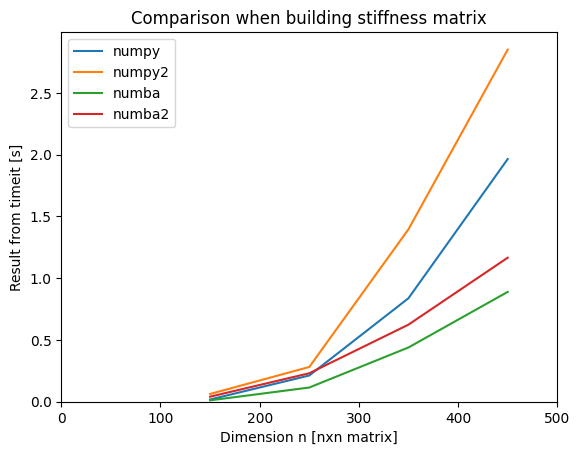

In [7]:
import numpy as np
import matplotlib.pyplot as plt

#pre-allocate
results_func1 = []
results_func2 =[]
results_func3 =[]
results_func4 =[]
dim = []
for n in range(150,550,100):
    res = %timeit -o -q -r 7 numpy_build_stiffness_matrix(n)
    results_func1.append(np.mean(res.timings[1:]))
    
    res = %timeit -o -q -r 7 numpy2_build_stiffness_matrix(n)
    results_func2.append(np.mean(res.timings[1:]))
    
    L=1
    Ck = 1
    ke1 = np.tile(np.array([
                [ 12,    6*L,   -12,   -6*L],
                [6*L,  4*L*L,  -6*L,  2*L*L],
                [-12,   -6*L,    12,    6*L],
                [6*L,  2*L*L,  -6*L,  4*L*L],
            ], dtype=float) * Ck / L**3, (n,1,1))
        
    ke2 = np.tile(np.array([
                [ 12,    6*L,   -12,   -6*L],
                [6*L,  4*L*L,  -6*L,  2*L*L],
                [-12,   -6*L,    12,    6*L],
                [6*L,  2*L*L,  -6*L,  4*L*L],
            ], dtype=float) * Ck / L**3, (n,1,1))
    res = %timeit -o -q -r 7 numba_build_full_stiffness_matrix(n,ke1,ke2)
    results_func3.append(np.mean(res.timings[1:]))
    
    res = %timeit -o -q -r 7 numba2_build_stiffness_matrix(n)
    results_func4.append(np.mean(res.timings[1:]))
    
    dim.append(n)    

plt.plot(dim,results_func1,dim,results_func2,dim,results_func3,dim,results_func4)
plt.title('Comparison when building stiffness matrix')
plt.legend(['numpy', 'numpy2', 'numba', 'numba2'])
plt.xlabel('Dimension n [nxn matrix]')
plt.ylabel('Result from timeit [s]')
plt.xlim(0.,500)
plt.ylim(0, None)

(0.0, 2.7791710772083174)

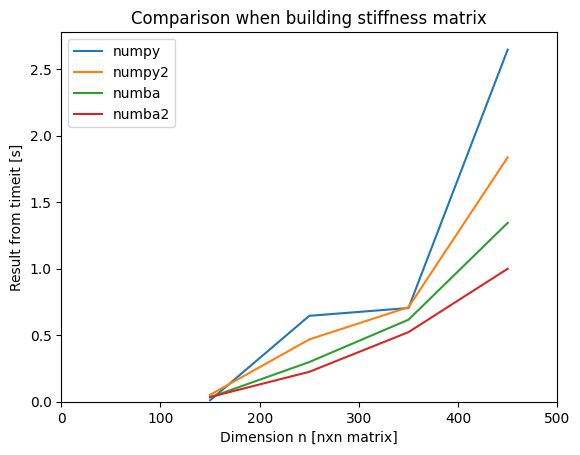

In [9]:
import numpy as np
import matplotlib.pyplot as plt

#pre-allocate
results_func1 = []
results_func2 =[]
results_func3 =[]
results_func4 =[]
dim = []
for n in range(150,550,100):
    res = %timeit -o -q -r 7 numpy_build_stiffness_matrix(n)
    results_func1.append(np.mean(res.timings[1:]))
    
    res = %timeit -o -q -r 7 numpy2_build_stiffness_matrix(n)
    results_func2.append(np.mean(res.timings[1:]))
    
    L=1
    Ck = 1
    ke1 = np.tile(np.array([
                [ 12,    6*L,   -12,   -6*L],
                [6*L,  4*L*L,  -6*L,  2*L*L],
                [-12,   -6*L,    12,    6*L],
                [6*L,  2*L*L,  -6*L,  4*L*L],
            ], dtype=float) * Ck / L**3, (n,1,1))
        
    ke2 = np.tile(np.array([
                [ 12,    6*L,   -12,   -6*L],
                [6*L,  4*L*L,  -6*L,  2*L*L],
                [-12,   -6*L,    12,    6*L],
                [6*L,  2*L*L,  -6*L,  4*L*L],
            ], dtype=float) * Ck / L**3, (n,1,1))
    res = %timeit -o -q -r 7 numba_build_full_stiffness_matrix(n,ke1,ke2)
    results_func3.append(np.mean(res.timings[1:]))
    
    res = %timeit -o -q -r 7 numba2_build_stiffness_matrix(n)
    results_func4.append(np.mean(res.timings[1:]))
    
    dim.append(n)    

plt.plot(dim,results_func1,dim,results_func2,dim,results_func3,dim,results_func4)
plt.title('Comparison when building stiffness matrix')
plt.legend(['numpy', 'numpy2', 'numba', 'numba2'])
plt.xlabel('Dimension n [nxn matrix]')
plt.ylabel('Result from timeit [s]')
plt.xlim(0.,500)
plt.ylim(0, None)